# Mapping mechanical errors on the reconstruction lattice
We consctruct a mechanical error model including offset and tiltin angles and map its effects on the reconstruction lattice of pupils (CTF's).

In [1]:
%reload_ext autoreload
%autoreload 2
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
from numpy import abs, angle
from pathlib import Path
from scipy.spatial.transform import Rotation as R

from fpmsample.simicro import SimMicroscope
from fpmsample import math
from phaseopt import data
import phasemath.coordinates as pmc
import phasemath.math as pmm

cfg = data.cfg_load()
sm = SimMicroscope(cfg=cfg)
sm.details()

# Defining the led matrix size
coordinate_grid = np.mgrid[-1:2, -1:2]
vectors = coordinate_grid.reshape(2,-1)
vectors = list(zip(*vectors))
# Adding tilt on the phi angle
corr_vecs = pmc.projected_corrections(vectors, sm, euler_triplet=[0, 1, 0])
xphi, yphi = zip(*corr_vecs)


Original size: 300
Pupil radius: 17 pixels
mk: 3, patch size: 100
Max phi given by NA_syn: 36.9
Synthetic NA: 0.70
Led overlap 69.5
Total simulated samples: 462


## Error projections on the lattice
Each tipe of mechanical error impacts in its own way on the projections of each source on the plane.

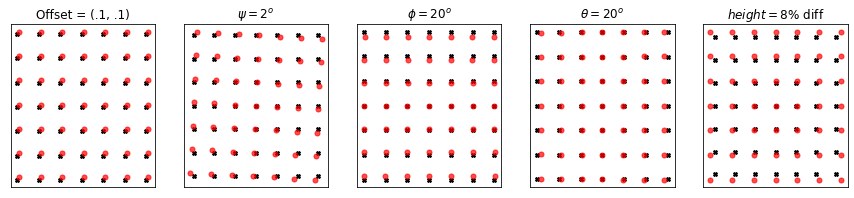

In [4]:
# Defining the led matrix size
coordinate_grid = np.mgrid[-3:4, -3:4]
vectors = coordinate_grid.reshape(2,-1)
vectors = list(zip(*vectors))
# Original errorless matrix
corr_vecs = pmc.projected_corrections(vectors, sm)
x, y = zip(*corr_vecs)
# Adding offset
corr_vecs = pmc.projected_corrections(vectors, sm, offset=[0.1, 0.1])
xoff, yoff = zip(*corr_vecs)
# Adding rotation over its own axis
corr_vecs = pmc.projected_corrections(vectors, sm, euler_triplet=[3, 0, 0])
xpsi, ypsi = zip(*corr_vecs)
# Adding tilt on the phi angle
corr_vecs = pmc.projected_corrections(vectors, sm, euler_triplet=[0, 20, 0])
xphi, yphi = zip(*corr_vecs)
# Adding tilt on the theta angle
corr_vecs = pmc.projected_corrections(vectors, sm, euler_triplet=[0, 0, 20])
xtheta, ytheta = zip(*corr_vecs)
# Adding tilt on the height
sm.height = 125
corr_vecs = pmc.projected_corrections(vectors, sm, euler_triplet=[0, 0, 0])
xh, yh = zip(*corr_vecs)
sm.height = 135
# Plot the results
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 3))
for ax in (ax1, ax2, ax3, ax4, ax5):
    ax.plot(x, y, 'Xk', markersize=4)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
ax1.plot(xoff, yoff, 'or', alpha=.7, markersize=5)
ax1.set_title('Offset = (.1, .1)')
ax2.plot(xpsi, ypsi, 'or', alpha=.7, markersize=5)
ax2.set_title('$\psi = 2^o$')
ax3.plot(xphi, yphi, 'or', alpha=.7, markersize=5)
ax3.set_title('$\phi = 20^o$')
ax4.plot(xtheta, ytheta, 'or', alpha=.7, markersize=5)
ax4.set_title('$\\theta = 20^o$')
ax5.plot(xh, yh, 'or', alpha=.7, markersize=5)
ax5.set_title('$height = 8\%$ diff')
plt.show()


All these mechanical errors can be included in the object model as if the object itself had some phase perturbation. For example, the adition fo an offset can be treated as a linear phase addition in the object.

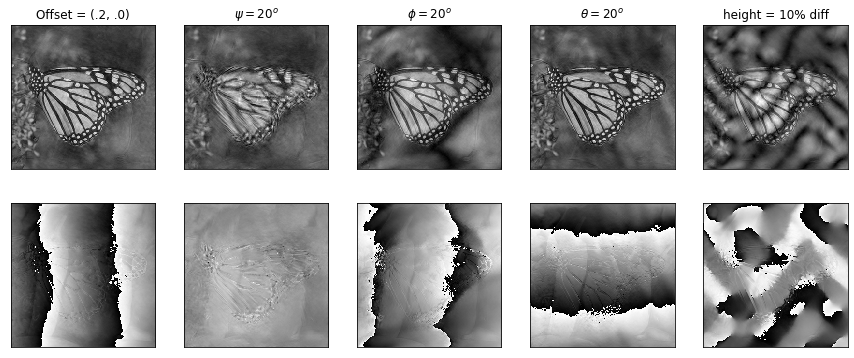

In [3]:
sol_path = Path('/home/juan/git/phaseopt/out')
sol_offset = np.load(sol_path/'sol_offset.npy')
sol_psi = np.load(sol_path/'sol_psi.npy')
sol_phi = np.load(sol_path/'sol_phi.npy')
sol_theta = np.load(sol_path/'sol_theta.npy')
sol_height = np.load(sol_path/'sol_height.npy')
titles = ['Offset = (.2, .0)', '$\psi = 20^o$', '$\phi = 20^o$', '$\\theta = 20^o$', 'height = 10% diff']
fig,  (axesh, axesl)= plt.subplots(2, 5, figsize=(15, 6))
for ax in np.array([axesh, axesl]).ravel():
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
def plot_solution(i, sol, title):
    axesh[i].imshow(np.abs(sol), cmap='gray')
    axesh[i].set_title(title)
    axesl[i].imshow(np.angle(sol), cmap='gray')
for i, sol in enumerate([sol_offset, sol_psi, sol_phi, sol_theta, sol_height]):
    plot_solution(i, sol, titles[i])    


Note these are not the only possible error conditions as pupil size is here not mentioned. Note however that pupil geometry can be generally corrected using an embeded approach such as the epie algorithm. 
Now, the hey idea is that every one of these errors can be equaly obtained in a direct approach. If we consider an object with an appropriate added phase disturbance. Considering a thin sample, and its phase distribution being

In [4]:
%%latex
\begin{align}
E(r) = \psi(r)e^{j (\varphi_x \hat{x} + \varphi_y \hat{y})},
\end{align}

<IPython.core.display.Latex object>

One wishes to find the magnitude and phase functions describing it. If a matrix offset is added, the efect on the reconstruction can be modeled as a linear phase added to the input

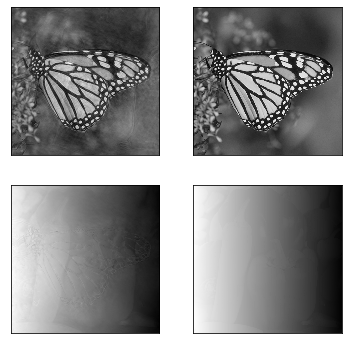

In [8]:
fig, (axesh, axesl) = plt.subplots(2,2, figsize=(6,6))
for ax in np.array([axesh, axesl]).ravel():
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
axesh[0].imshow(np.abs(sol_offset), cmap='gray')
axesl[0].imshow(pmm.unwrap_phase(sol_offset), cmap='gray')
xt = sm.complex_image
#sfft = np.roll(np.fft.fft2(xt), 1)
#xt = np.fft.ifft2(sfft)
xx, yy = np.mgrid[0:np.pi:300j, 0:np.pi:300j]
added_phase = np.exp(-1j*(0*xx+yy*2)*4)
xt_phase = xt*(added_phase)
axesh[1].imshow(np.abs(xt), cmap='gray')
axesl[1].imshow(pmm.unwrap_phase(xt_phase), cmap='gray')
plt.show()

## Statistical errors
Both Gaussian and Poisson error distribution were added to the led matrix as positioning errors. In the gaussian case planar random noise with the same variance in both axis was added

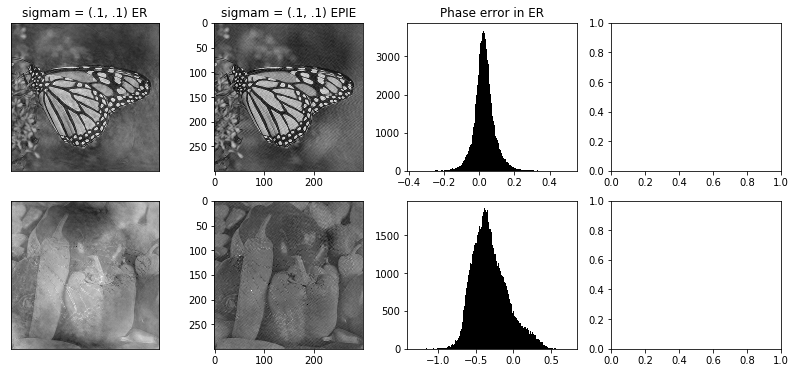

In [57]:
sol_dir = Path('/home/juan/git/phaseopt/out')
titles = ['sigmam = (.1, .1) ER', 'sigmam = (.1, .1) EPIE']
solutions = []
for sol_str in ['sol_gauss_er.npy', 'sol_gauss_epie.npy']:
    sol_path = sol_dir/sol_str
    solutions.append(np.load(sol_path))
fig,  (axesh, axesl)= plt.subplots(2, 4, figsize=(14, 6))
for ax in np.array([axesh[:1], axesl[:1]]).ravel():
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
for i, sol in enumerate([sol_gauss_er, sol_gauss_epie]):
    plot_solution(i, sol, titles[i])
def calculate_errors(xt, xrec):
    abs_err = np.abs(xt)/np.abs(xt).max()-np.abs(sol_gauss_er)/(np.abs(sol_gauss_er)).max()
    phase_err = pmm.unwrap_phase(xt)-pmm.unwrap_phase(sol_gauss_er)
    return abs_err.ravel(), phase_err.ravel()
axesh[2].set_title('Absolute error in ER')
abs_err, phase_err = calculate_errors(xt, solutions[0])
axesh[2].hist(abs_err, bins=200, color='k')
axesh[2].set_title('Phase error in ER')
axesl[2].hist(phase_err, bins=200,color='k')
plt.show()

sol_path = Path('/home/juan/git/phaseopt/out')
sol_reset_er = np.load(sol_path/'sol_reset_er.npy')
sol_reset_epie = np.load(sol_path/'sol_reset_epie.npy')
titles = ['var 50 ER', 'var 50 EPIE']
fig,  (axesh, axesl)= plt.subplots(2, 2, figsize=(6, 6))
for ax in np.array([axesh, axesl]).ravel():
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
for i, sol in enumerate([sol_reset_er, sol_reset_epie]):
    plot_solution(i, sol, titles[i])
plt.show()

## Led distance and pupil overlap

In [42]:
def r_overlap(na, gap ,height): 
    rl = na*np.sqrt(gap**2+height**2)/gap
    rl = na*height/gap
    rol = (2*np.arccos(1/2/rl)-1/rl*np.sqrt(1-(1/2/rl)**2))/np.pi
    t = (2*np.arccos(6/(2*0.1*100)) - (6/(0.1*100))*np.sqrt(1- (6/(2*0.1*100))**2) )/np.pi
    print(rol)
    return rol

r_overlap(0.08, 6, 120)

0.6086870122388774


0.6086870122388774